# CNN 遥感图像分类项目

## 数据说明
This is a 21 class land use image dataset meant for research purposes. 
There are 100 images for each of the following classes:
+ agricultural
+ airplane
+ baseballdiamond
+ beach
+ buildings
+ chaparral
+ denseresidential
+ forest
+ freeway
+ golfcourse
+ harbor
+ intersection
+ mediumresidential
+ mobilehomepark
+ overpass
+ parkinglot
+ river
+ runway
+ sparseresidential
+ storagetanks
+ tenniscourt

Each image measures 256x256 pixels.

The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. The pixel resolution of this public domain imagery is 1 foot.

Download site: http://weegee.vision.ucmerced.edu/datasets/landuse.html

# 1. 读取原始数据和文件

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D, Dropout, Flatten, add, Reshape
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from skimage.transform import resize
import cv2

from PIL import Image
import os
from shutil import copyfile

In [2]:
#!pip freeze 

In [3]:
print(keras.__version__)

2.4.0


## Load image data

Select 2 categories only for the project to reduce the computation time

In [4]:
category_names = [
 'agricultural',
 'forest',
]

Filename format sample: agricultural00.tif

In [5]:
Image_directory = 'data/UCMerced_LandUse/Images'

In [6]:
num_images = 100  # per category
nb_classes = len(category_names)
patch_size = 256  # width and height in pixel
channels = 3

In [7]:
# Load the original dataset
images_orig = []
labels_num = []
for i in range(len(category_names)):    
    # load all images per class
    for j in range(num_images):        
        img_path = os.path.join(Image_directory, category_names[i], category_names[i]+'{:02d}.tif'.format(j))
        
        new_image = plt.imread(img_path) 
        resized_image = resize(new_image, (patch_size/4, patch_size/4, channels))
        arr = np.asarray(resized_image)
        images_orig.append(arr)
        labels_num.append([i])

images_orig = np.array(images_orig)
#images_orig  = (images_orig  - np.mean(images_orig )) #/ np.std(images_orig)


labels_num = np.array(labels_num)

# Save the numpy datasets
np.save('data/UCMerced_images_orig_2Class.npy', images_orig)
np.save('data/UCMerced_labels_num_2Class.npy', labels_num)      

In [8]:
# Load the numpy datasets
images_orig = np.load('data/UCMerced_images_orig_2Class.npy')
labels = np.load('data/UCMerced_labels_num_2Class.npy')

#### label is 0 or 1, no need to one-hot

In [9]:
print('\nLabel: \n{}'.format(labels[[1,101]]))

print('\nImages shape: {}'.format(images_orig.shape))
print('\nLabel shape: {}'.format(labels.shape))


Label: 
[[0]
 [1]]

Images shape: (200, 64, 64, 3)

Label shape: (200, 1)


## Visualize the images



agricultural
(100, 64, 64, 3)


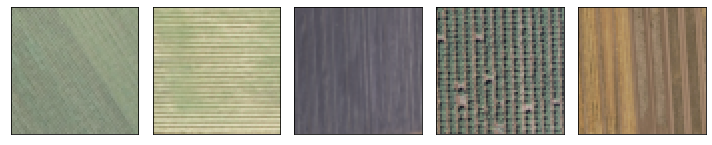

forest
(100, 64, 64, 3)


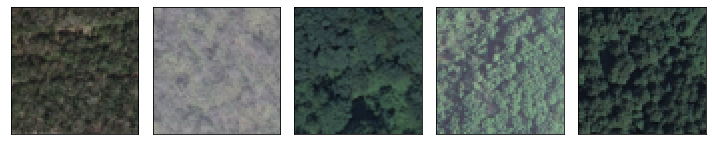

In [10]:
# VISUALIZE IMAGES
def plotImages( images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    plt.show()

# Plot some examples for each category    
def plot_examples_per_category():
    for i in range(nb_classes):
        print(category_names[i])
        images_to_print = images_orig[i*num_images:(i+1)*num_images]
        np.random.seed(2020)
        np.random.shuffle(images_to_print)
        print(images_to_print.shape)
        plotImages(images_to_print)

plot_examples_per_category()

# 2. Split train, val and test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(images_orig, labels, 
                                                    test_size=0.2, 
                                                    stratify = labels, 
                                                    random_state=2021)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  stratify = y_train,
                                                  random_state=2021) 

# 0.25 x 0.8 = 0.2

In [12]:
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape,)

(120, 64, 64, 3) (40, 64, 64, 3) (40, 64, 64, 3) (120, 1) (40, 1) (40, 1)


Check how many images per class in train/val/test

In [13]:
def unique_counts(arr):
    unique, counts = np.unique(arr,  return_counts=True)
    print(dict(zip(unique, counts)))

In [14]:
unique_counts(y_train)
unique_counts(y_val)
unique_counts(y_test)

{0: 60, 1: 60}
{0: 20, 1: 20}
{0: 20, 1: 20}


# 3. Build CNN Base Model 

**Task**: Implement the following convolutional neural network (CNN). Consider the information in the Figure as well as the additional remarks:

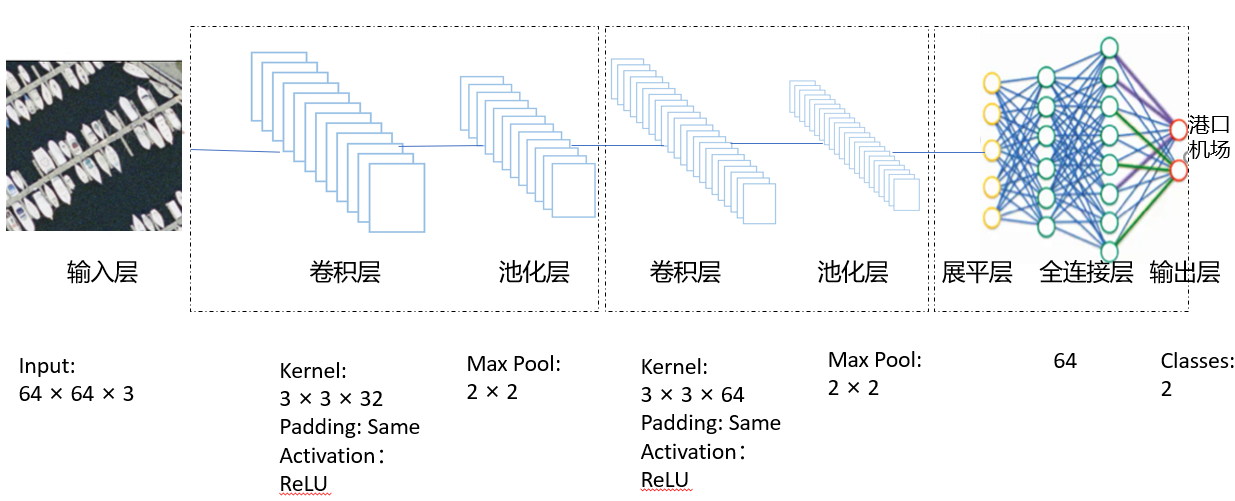


In [22]:
# parameters:
input_shape = (int(patch_size/4), int(patch_size/4), channels)
pool_size = (2, 2)                  # size of pooling area for max pooling
prob_drop_hidden = 0.5              # drop probability for dropout @ dense layer

def define_CNN_base():

    model = Sequential()

    # conv1 layer
    model.add(Conv2D(filters=32, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                     input_shape=input_shape))    
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    # conv2 layer
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                   ))    
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    model.add(Flatten())

    # fc1 layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # The output of the model (sigmoid)
    model.add(Dense(1, activation='sigmoid'))

    return model

# clear the session first, such that layer names start with index 1
K.clear_session()
model_CNN_base = define_CNN_base()

In [23]:
model_CNN_base.layers

In [24]:
# provide model summary info
model_CNN_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1048640   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In a 2D convolutional network,the expected input is (batchSize, height, width, channels).

The first dimension in a keras model is always the batch size. You don't need fixed batch sizes.
`
That's why this dimension is often ignored when you define your model. The batch size will be then automatically defined in the fit or predict methods.

# 4. Train the base model

#### What is epoch
Number epoch equal to the number of times the algorithm sees the entire data set. So, each time the algorithm has seen all samples in the dataset, one epoch has completed.

#### What is batch size
Batch size is the number of items from the data to takes the training model. If you use the batch size of one you update weights after every sample. If you use batch size 32, you calculate the average error and then update weights every 32 items.

For instance, let’s say you have 24000 training samples and you want to set up a batch size equal to 32. The algorithm takes the first 32 samples from the training dataset and trains the network. Next, it takes the second 32 samples and trains the network again. We can keep doing this procedure until we have propagated all samples through the network.

#### What is iteration
Every time you pass a batch of data through the neural network, you completed one iteration. In the case of neural networks, that means the forward pass and backward pass. So, batch size * number of iterations = epoch

Iterative calculations on a portion of the data to save time and computational resources.

#### Epoch vs iteration
One epoch includes all the training examples whereas one iteration includes only one batch of training examples.


In general, a batch size of 32 is a good starting point, and you should also try with 64, 128, and 256. 

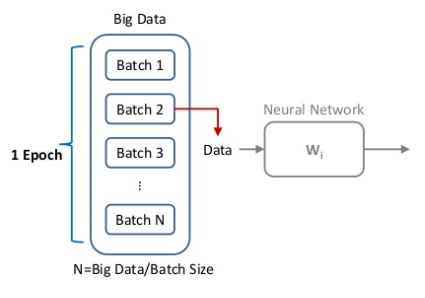

In [25]:
# Set hyper parameters
epochs = 50
base_learning_rate=0.0001
batch_size = 32

In [26]:
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((120, 64, 64, 3), (40, 64, 64, 3), (120, 1), (40, 1))

In [27]:
# set your architecture
model = define_CNN_base()

Compile the model with loss and the Adam optimizer.

In [28]:
# Define an adam optimizer
opt = Adam(lr=base_learning_rate)

model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])        

Training commences by making a call to the fit method with our training and validation sets

In [29]:
# Fit the model parameters
print('training...')

# Use X_train, y_train, X_val, y_val as train and validation data
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,  
                           verbose=2, validation_data=(X_val,y_val))

print('done')

training...
Epoch 1/50
4/4 - 0s - loss: 0.7206 - accuracy: 0.4667 - val_loss: 0.6752 - val_accuracy: 0.5000
Epoch 2/50
4/4 - 0s - loss: 0.6594 - accuracy: 0.5083 - val_loss: 0.6653 - val_accuracy: 0.5000
Epoch 3/50
4/4 - 0s - loss: 0.6594 - accuracy: 0.5250 - val_loss: 0.6525 - val_accuracy: 0.5000
Epoch 4/50
4/4 - 0s - loss: 0.6309 - accuracy: 0.5833 - val_loss: 0.6335 - val_accuracy: 0.7500
Epoch 5/50
4/4 - 0s - loss: 0.6483 - accuracy: 0.6750 - val_loss: 0.6201 - val_accuracy: 0.7500
Epoch 6/50
4/4 - 0s - loss: 0.6072 - accuracy: 0.7583 - val_loss: 0.6078 - val_accuracy: 0.6750
Epoch 7/50
4/4 - 0s - loss: 0.5666 - accuracy: 0.7000 - val_loss: 0.5800 - val_accuracy: 0.7500
Epoch 8/50
4/4 - 0s - loss: 0.5625 - accuracy: 0.7750 - val_loss: 0.5451 - val_accuracy: 0.7500
Epoch 9/50
4/4 - 0s - loss: 0.5387 - accuracy: 0.8333 - val_loss: 0.5174 - val_accuracy: 0.8000
Epoch 10/50
4/4 - 0s - loss: 0.5094 - accuracy: 0.8333 - val_loss: 0.4925 - val_accuracy: 0.7500
Epoch 11/50
4/4 - 0s - loss

Plotting training accuracy/loss curves

In [30]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
#history.history

In [31]:
# list all data in history
print(history.history['val_loss'])

[0.6751710772514343, 0.6653217673301697, 0.6524686217308044, 0.6335260272026062, 0.6201136112213135, 0.607848048210144, 0.5800354480743408, 0.5450872778892517, 0.5174302458763123, 0.49247056245803833, 0.46462827920913696, 0.4419524669647217, 0.42643848061561584, 0.3978996276855469, 0.3790803849697113, 0.36363714933395386, 0.3591412901878357, 0.3394688069820404, 0.35100284218788147, 0.31659644842147827, 0.32095304131507874, 0.32284313440322876, 0.30100521445274353, 0.29302242398262024, 0.28405308723449707, 0.2839180827140808, 0.27289578318595886, 0.273508220911026, 0.256427139043808, 0.2706400752067566, 0.24276289343833923, 0.23986735939979553, 0.25621140003204346, 0.23368892073631287, 0.2290155589580536, 0.22384348511695862, 0.22580799460411072, 0.22255733609199524, 0.23571336269378662, 0.21683287620544434, 0.21294279396533966, 0.22986021637916565, 0.21108567714691162, 0.2134174406528473, 0.2049054205417633, 0.20175763964653015, 0.19824667274951935, 0.19518154859542847, 0.2017187625169

In [32]:
def history_plot(model_id, history):
	plt.figure(figsize=(8,10)) 
	# plot loss
	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss - ' + model_id, fontsize = 12)
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.xlabel("Epochs",fontsize = 12)
	plt.ylabel("Loss", fontsize = 12)
	plt.legend(loc='upper right')

	# plot accuracy
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy ' + model_id, fontsize = 10)
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.xlabel("Epochs", fontsize = 12)
	plt.ylabel("Accuracy", fontsize = 12)
	plt.legend(loc='lower right')

	plt.show()

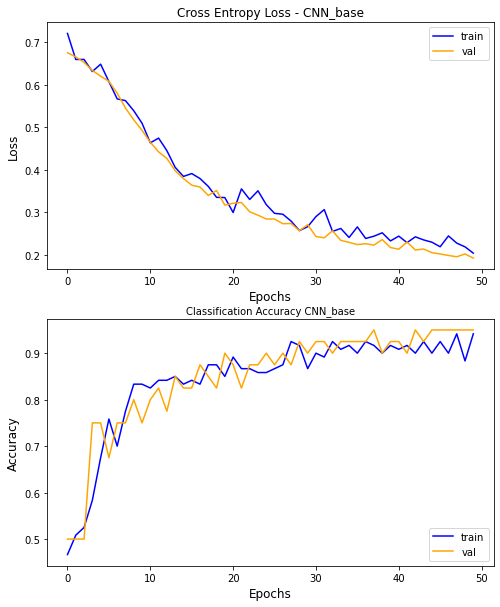

In [33]:
history_plot('CNN_base', history)

#### Saving our model to disk

A Keras model consists of multiple components:

+ An architecture, or configuration, which specifies what layers the model contain, and how they're connected.
+ A set of weights values (the "state of the model").
+ An optimizer (defined by compiling the model).
+ A set of losses and metrics (defined by compiling the model or calling add_loss() or add_metric()).
The Keras API makes it possible to save all of these pieces to disk at once, or to only selectively save some of them:

+ Saving everything into a single archive in the TensorFlow SavedModel format (or in the older Keras H5 format). This is the standard practice.
+ Saving the architecture / configuration only, typically as a JSON file.
+ Saving the weights values only. This is generally used when training the model.

Save to H5 format

In [34]:
MODEL_PATH = 'model/test/'

In [35]:
model.save(MODEL_PATH+'CNN_base_2classes.h5', save_format="h5")

In [36]:
model = load_model(MODEL_PATH+'CNN_base_2classes.h5')

In [37]:
os.listdir(MODEL_PATH)

['CNN_base_2classes.h5', 'CNN_base_2classes_default']

Save to tensorflow format

In [38]:
MODEL_PATH = 'model/test/'

In [39]:
model.save(MODEL_PATH+'CNN_base_2classes_default')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/test/CNN_base_2classes_default\assets


In [40]:
model = load_model(MODEL_PATH+'CNN_base_2classes_default')

In [41]:
os.listdir(MODEL_PATH)

['CNN_base_2classes.h5', 'CNN_base_2classes_default']

In [42]:
!dir model\test\CNN_base_2classes_default

 Volume in drive C is Windows-SSD
 Volume Serial Number is 4ADE-FAD3

 Directory of C:\Users\jianx\git2020\CNN_RemSen\model\test\CNN_base_2classes_default

12/04/2020  03:00 PM    <DIR>          .
12/04/2020  03:00 PM    <DIR>          ..
12/03/2020  07:45 PM    <DIR>          assets
12/04/2020  03:00 PM           140,637 saved_model.pb
12/04/2020  03:00 PM    <DIR>          variables
               1 File(s)        140,637 bytes
               4 Dir(s)  120,980,885,504 bytes free


In [43]:
!dir model\test\CNN_base_2classes_default\variables

 Volume in drive C is Windows-SSD
 Volume Serial Number is 4ADE-FAD3

 Directory of C:\Users\jianx\git2020\CNN_RemSen\model\test\CNN_base_2classes_default\variables

12/04/2020  03:00 PM    <DIR>          .
12/04/2020  03:00 PM    <DIR>          ..
12/04/2020  03:00 PM        12,824,074 variables.data-00000-of-00001
12/04/2020  03:00 PM             2,297 variables.index
               2 File(s)     12,826,371 bytes
               2 Dir(s)  120,980,549,632 bytes free


# 5. Prediction on test image

In [44]:
model.evaluate(X_train, y_train, verbose=0)

[0.19530434906482697, 0.9416666626930237]

In [45]:
_, acc = model.evaluate(X_train, y_train, verbose=0)
print('Model evaluate on train, Accuracy %.3f' % (acc * 100.0))

_, acc = model.evaluate(X_val, y_val, verbose=0)
print('Model evaluate on val, Accuracy %.3f' % (acc * 100.0))

_, acc = model.evaluate(X_test, y_test, verbose=0)
print('Model evaluate on test, Accuracy %.3f' % (acc * 100.0))
acc_test = round(100*acc,2)

Model evaluate on train, Accuracy 94.167
Model evaluate on val, Accuracy 95.000
Model evaluate on test, Accuracy 92.500


In [46]:
# predict on X_test
print('predicting...')
predictions = model.predict(x=X_test)

predicting...


In [47]:
predictions.shape

(40, 1)

In [48]:
predictions[0]

array([0.99195975], dtype=float32)

In [49]:
# convert predictions    
#predictions_num = np.argmax(predictions, axis=1)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

In [50]:
y_pred[0]

array([1])